In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/002412MB5.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/006146MK4.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/24.jpgMA7.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/017005MZ4.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/06.jpgMA8.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/004494MI4.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/003738MD9.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/000203MD4.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/008122MM4.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/001204MA5.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/003817MD9.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/002407MB5.jpg
/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/

In [2]:
#name of the directories
os.listdir("../input/sheep-breed-classification/SheepFaceImages")

['Marino', 'Suffolk', 'Poll Dorset', 'White Suffolk']

In [3]:
Marino = "/kaggle/input/sheep-breed-classification/SheepFaceImages/Marino/"
WhiteSuffolk = "/kaggle/input/sheep-breed-classification/SheepFaceImages/White Suffolk"
PollDorset = "/kaggle/input/sheep-breed-classification/SheepFaceImages/Poll Dorset"
Suffolk = "/kaggle/input/sheep-breed-classification/SheepFaceImages/Suffolk"


In [4]:
from tqdm import tqdm 
x = []
y = []

def create_dataset(dirname,breedname):
    for i in tqdm(os.listdir(dirname)):
        path = os.path.join(dirname,i)
        try:
            img = cv2.imread(path)
            img = cv2.resize(img,(150,150))
        except:
            continue
            
        x.append(img)
        y.append(breedname)
    return x,y
        

In [5]:
x,y = create_dataset(Marino,"Marino")
x,y = create_dataset(WhiteSuffolk,"White Suffolk")
x,y = create_dataset(PollDorset,"Poll Dorset")
x,y = create_dataset(Suffolk,"Suffolk")

100%|██████████| 420/420 [00:01<00:00, 297.52it/s]


In [6]:
x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(1680, 150, 150, 3) (1680,)


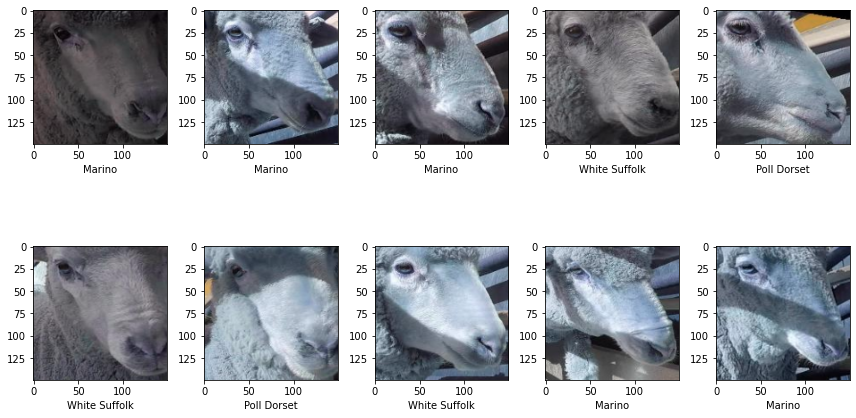

In [7]:
plt.figure(figsize = (12,7))
for i in range(10):
    indx = random.randint(0,len(y))
    img = x[indx]
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(img)
    plt.xlabel(y[indx])

plt.tight_layout()
plt.show()
    

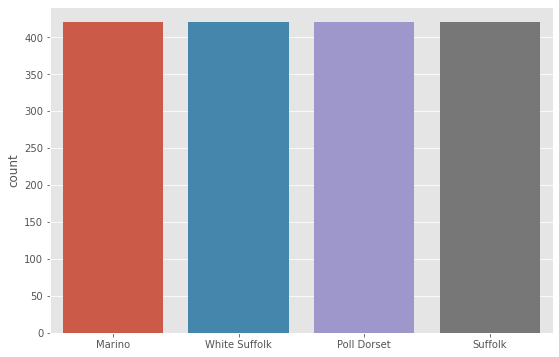

In [8]:
plt.style.use("ggplot")
plt.figure(figsize=(9,6))
sns.countplot(y)
plt.show()

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

In [10]:
#divide our dataset into train & test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [11]:
img_size=150
x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0

x_train = x_train.reshape(-1,img_size,img_size,3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size,img_size,3)
y_test = np.array(y_test)

In [12]:
#ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
resnet = ResNet50(weights = "imagenet",include_top = False,input_shape=(150,150,3))

94773248/94765736 [==============================] - 1s 0us/step


In [13]:
for layer in resnet.layers:
    layer.trainable = False

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout

model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(4,activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 204804    
Total params: 23,792,516
Trainable params: 204,804
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("resnet50.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=8,verbose=1)

model.compile(optimizer="adam",loss = "categorical_crossentropy",metrics = ["accuracy"])

In [16]:
history = model.fit(x_train,y_train,batch_size=32,validation_data = (x_test,y_test),
                    epochs=25,verbose=1,callbacks = [checkpoint,earlystop])

Epoch 1/25
41/42 [============================>.] - ETA: 0s - loss: 1.6690 - accuracy: 0.3148
Epoch 00001: val_accuracy improved from -inf to 0.25298, saving model to resnet50.h5
42/42 [==============================] - 4s 83ms/step - loss: 1.6653 - accuracy: 0.3177 - val_loss: 1.6103 - val_accuracy: 0.2530
Epoch 2/25
41/42 [============================>.] - ETA: 0s - loss: 1.3735 - accuracy: 0.3651
Epoch 00002: val_accuracy improved from 0.25298 to 0.48512, saving model to resnet50.h5
42/42 [==============================] - 2s 52ms/step - loss: 1.3743 - accuracy: 0.3609 - val_loss: 1.2632 - val_accuracy: 0.4851
Epoch 3/25
41/42 [============================>.] - ETA: 0s - loss: 1.2535 - accuracy: 0.4474
Epoch 00003: val_accuracy improved from 0.48512 to 0.56250, saving model to resnet50.h5
42/42 [==============================] - 2s 52ms/step - loss: 1.2527 - accuracy: 0.4457 - val_loss: 1.1190 - val_accuracy: 0.5625
Epoch 4/25
41/42 [============================>.] - ETA: 0s - loss:

In [17]:
loss,accuracy = model.evaluate(x_test,y_test)
print(f"Loss for resnet50: {loss}")
print(f"Accuracy for resnet50: {accuracy}")

11/11 [==============================] - 0s 30ms/step - loss: 0.8585 - accuracy: 0.6250
Loss for resnet50: 0.8584846258163452
Accuracy for resnet50: 0.625


In [18]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
y_pred = model.predict_classes(x_test)
y_pred[:15]

array([1, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0, 0, 3, 0])

In [19]:
y_test_resnet = np.argmax(y_test,axis=1)
y_test_resnet[:15]

array([1, 2, 3, 3, 3, 0, 3, 3, 3, 2, 3, 2, 0, 3, 1])

In [20]:
print(classification_report(y_test_resnet,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.48      0.58        82
           1       1.00      0.21      0.35        95
           2       0.78      0.92      0.84        74
           3       0.47      0.98      0.64        85

    accuracy                           0.62       336
   macro avg       0.75      0.65      0.60       336
weighted avg       0.75      0.62      0.59       336



In [21]:
#VGG19
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights = "imagenet",include_top = False,input_shape=(150,150,3))

80142336/80134624 [==============================] - 1s 0us/step


In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [23]:
model2 = Sequential()
model2.add(vgg)
model2.add(Flatten())
model2.add(Dense(4,activation = "softmax"))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 32772     
Total params: 20,057,156
Trainable params: 32,772
Non-trainable params: 20,024,384
_________________________________________________________________


In [24]:
checkpoint2 = ModelCheckpoint("vgg19.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
earlystop2 = EarlyStopping(monitor="val_accuracy",patience=8,verbose=1)
model2.compile(optimizer="adam",loss = "categorical_crossentropy",metrics = ["accuracy"])

history2 = model2.fit(x_train,y_train,batch_size=32,validation_data = (x_test,y_test),
                    epochs=25,verbose=1,callbacks = [checkpoint2,earlystop2])

Epoch 1/25
41/42 [============================>.] - ETA: 0s - loss: 1.0788 - accuracy: 0.5419
Epoch 00001: val_accuracy improved from -inf to 0.77679, saving model to vgg19.h5
42/42 [==============================] - 3s 67ms/step - loss: 1.0776 - accuracy: 0.5424 - val_loss: 0.7276 - val_accuracy: 0.7768
Epoch 2/25
41/42 [============================>.] - ETA: 0s - loss: 0.6382 - accuracy: 0.8163
Epoch 00002: val_accuracy improved from 0.77679 to 0.83333, saving model to vgg19.h5
42/42 [==============================] - 2s 56ms/step - loss: 0.6370 - accuracy: 0.8185 - val_loss: 0.5635 - val_accuracy: 0.8333
Epoch 3/25
41/42 [============================>.] - ETA: 0s - loss: 0.4932 - accuracy: 0.8491
Epoch 00003: val_accuracy improved from 0.83333 to 0.84524, saving model to vgg19.h5
42/42 [==============================] - 2s 55ms/step - loss: 0.4912 - accuracy: 0.8504 - val_loss: 0.5301 - val_accuracy: 0.8452
Epoch 4/25
41/42 [============================>.] - ETA: 0s - loss: 0.3860 -

In [25]:
loss2,accuracy2 = model2.evaluate(x_test,y_test)
print(f"Loss for vgg19: {loss2}")
print(f"Accuracy for vgg19: {accuracy2}")

11/11 [==============================] - 0s 38ms/step - loss: 0.2444 - accuracy: 0.9107
Loss for vgg19: 0.24443109333515167
Accuracy for vgg19: 0.9107142686843872


In [26]:
#Resnet50 gives 73% accuracy on the other hand VGG19 gives 92% accuracy
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
y_pred = model2.predict_classes(x_test)
y_pred[:15]

array([1, 2, 3, 3, 3, 0, 3, 3, 3, 2, 3, 2, 0, 3, 0])

In [27]:
y_test_vgg = np.argmax(y_test,axis=1)
y_test_vgg[:15]

array([1, 2, 3, 3, 3, 0, 3, 3, 3, 2, 3, 2, 0, 3, 1])

In [28]:
print(classification_report(y_test_vgg,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        82
           1       0.92      0.87      0.90        95
           2       0.96      0.93      0.95        74
           3       0.95      0.94      0.95        85

    accuracy                           0.91       336
   macro avg       0.91      0.91      0.91       336
weighted avg       0.91      0.91      0.91       336



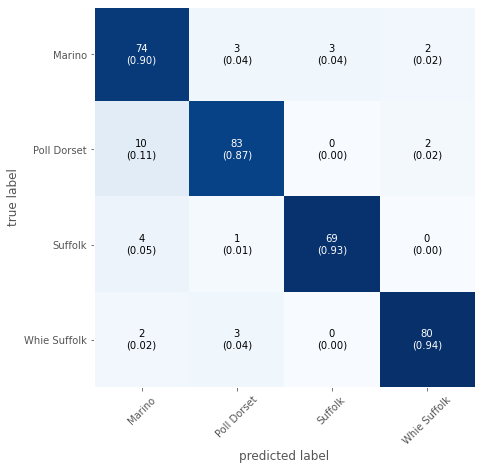

In [29]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test_vgg,y_pred)
plot_confusion_matrix(conf_mat = cm,show_normed= True,class_names = ["Marino","Poll Dorset","Suffolk",
                                                                     "Whie Suffolk"],figsize=(8,7));

In [30]:
def plot_learning_curve_for_resnet(history,epochs):
    plt.style.use("ggplot")
    plt.figure(figsize=(12,6))
    epochs = np.arange(1,epochs+1)
    plt.subplot(2,2,1)
    plt.plot(epochs,history.history["accuracy"],"go-")
    plt.plot(epochs,history.history["val_accuracy"],"ro-")
    plt.title("Model Accuracy Curve for ResNet50")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"],loc = "upper left")
    
    plt.subplot(2,2,2)
    plt.plot(epochs,history.history["loss"],"go-")
    plt.plot(epochs,history.history["val_loss"],"ro-")
    plt.title("Model Loss Curve for ResNet50")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Val"],loc = "upper left")
    
    plt.show()
    

In [31]:
def plot_learning_curve_for_vgg(history,epochs):   
    plt.style.use("ggplot")
    plt.figure(figsize=(12,6))
    epochs = np.arange(1,epochs+1)
    plt.subplot(1,2,1)
    plt.plot(epochs,history.history["accuracy"],"go-")
    plt.plot(epochs,history.history["val_accuracy"],"ro-")
    plt.title("Model Accuracy Curve for VGG19")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"],loc = "upper left")
    
    plt.subplot(1,2,2)
    plt.plot(epochs,history.history["loss"],"go-")
    plt.plot(epochs,history.history["val_loss"],"ro-")
    plt.title("Model Loss Curve for VGG19")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Val"],loc = "upper left")
    plt.show()

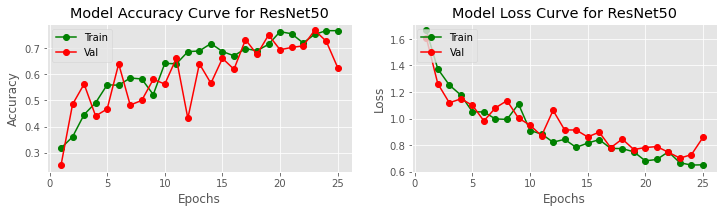

In [32]:
plot_learning_curve_for_resnet(history,25)

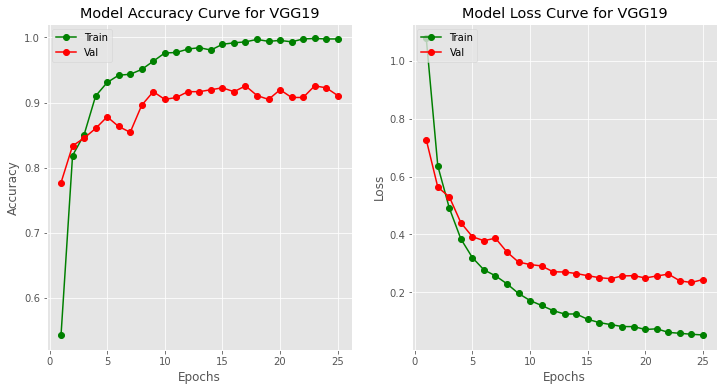

In [33]:
plot_learning_curve_for_vgg(history2,25)

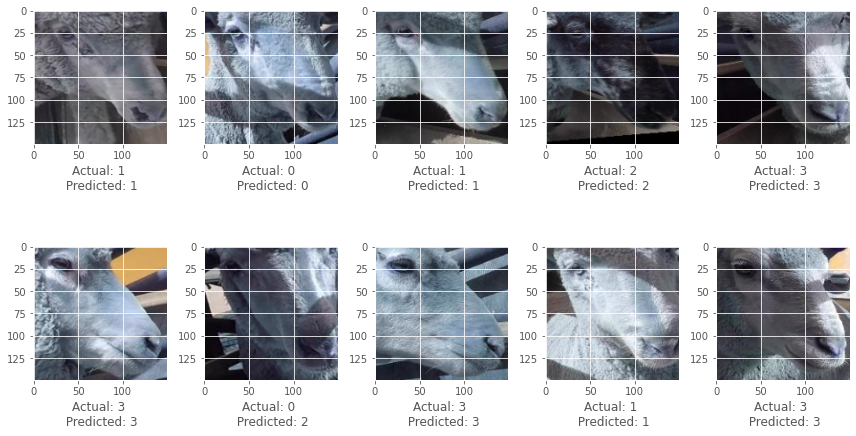

In [34]:
plt.figure(figsize=(12,7))
for i in range(10):
    indx = random.randint(0,len(y_test_vgg))
    plt.subplot(2,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(x_test[indx])
    plt.xlabel(f"Actual: {y_test_vgg[indx]} \n Predicted: {y_pred[indx]}")
    
plt.tight_layout()
plt.show()
    